## Thinkful Data Science Bootcamp

## Tecnical Take-Home Exam

#### Emile Badran - Oct/11/2018

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import multiprocessing
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn import ensemble

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


Using the data in the link below, attempt to model a customer’s propensity to join our loyalty program:

https://bit.ly/2Etq2Ux

In [2]:
cust_data = pd.read_csv('/Users/Badran/Desktop/customers_data.csv',index_col=0)
cust_data.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,male,no,31.0,35.0,False
1,65.16,male,yes,23.0,61.0,False
2,40.60,female,no,36.0,49.0,False
3,38.01,male,yes,47.0,57.0,False
4,22.32,female,yes,5.0,39.0,False


In [3]:
# inspect the data types
cust_data.dtypes

purch_amt                float64
gender                    object
card_on_file              object
age                      float64
days_since_last_purch    float64
loyalty                     bool
dtype: object

In [4]:
# check for null values
cust_data[cust_data.isnull().any(axis=1)]

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty


In [5]:
# check class (im)balance
cust_data.loyalty.value_counts()

False    100000
True      20000
Name: loyalty, dtype: int64

In [6]:
# check the integrity of categorical variables
cust_data.gender.value_counts()

male      60181
female    59819
Name: gender, dtype: int64

In [7]:
# check the integrity of categorical variables
cust_data.card_on_file.value_counts()

yes    60087
no     59913
Name: card_on_file, dtype: int64

In [8]:
# Convert target column to binary
cust_data.loyalty = cust_data.loyalty.apply(lambda x: 0 if x==False else 1)

# Convert categorical columns to binary
cust_data.gender = cust_data.gender.apply(lambda x: 0 if x=='male' else 1)
cust_data.card_on_file = cust_data.card_on_file.apply(lambda x: 0 if x=='no' else 1)

#### Attribute Information:

- purch_amt: float64
- gender: 0=male, 1=female
- card_on_file: 0=no, 1=yes
- age: float64
- days_since_last_purch: float64
- loyalty: 0=no, 1=yes

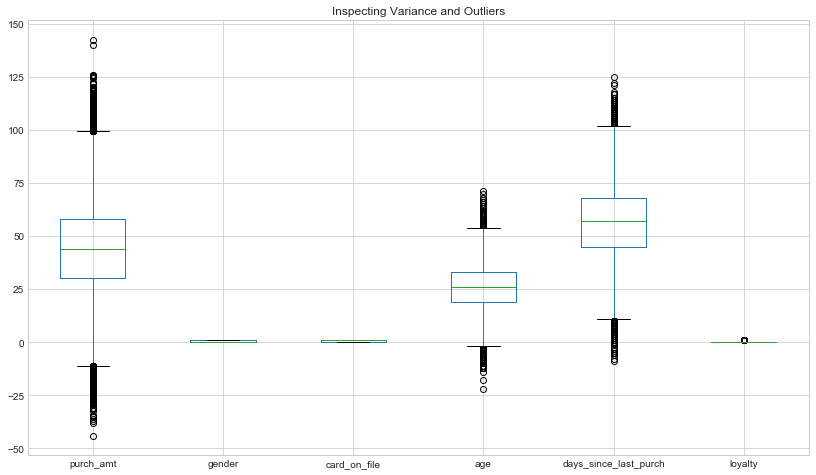

In [9]:
# Plot a boxplot to inspect variance
cust_data.boxplot(figsize=(14,8), grid=True)
plt.title('Inspecting Variance and Outliers')
plt.show()

In [10]:
# there are negative age and days_since_last_purch values
cust_data.describe()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000
mean,44.036234,0.498492,0.500725,25.803008,56.605908,0.166667
std,20.473148,0.500000,0.500002,10.153072,16.422187,0.372680
min,-43.950000,0.000000,0.000000,-22.000000,-9.000000,0.000000
25%,30.210000,0.000000,0.000000,19.000000,45.000000,0.000000
50%,43.970000,0.000000,1.000000,26.000000,57.000000,0.000000
75%,57.830000,1.000000,1.000000,33.000000,68.000000,0.000000
max,142.200000,1.000000,1.000000,71.000000,125.000000,1.000000


There are negative "age" and "days since last purchase" values, which doesn't make sense. We'll drop those rows.

We'll consider the negative "purchase values" as reimbursements. 

Other than that, there are some outliers in the purchase values, but nothing uncommon.

In [11]:
# delete negative age and days_since_last_purch values
cust_data = cust_data[cust_data.age >= 10] # keep only customers with age +10
cust_data = cust_data[cust_data.days_since_last_purch >= 0]

# reset the index
cust_data.reset_index(inplace=True, drop=True)
cust_data.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,0,0,31.0,35.0,0
1,65.16,0,1,23.0,61.0,0
2,40.60,1,0,36.0,49.0,0
3,38.01,0,1,47.0,57.0,0
4,43.96,0,1,36.0,64.0,0


#### Inspecting variable correlation
The correlation heatmap displays the Pearson's Standard Correlation Coefficient (r). Our correlation analysis indicates that the customers with more recent purchases tend to **not** be part of the loyalty program (r=-0.46).

On the other hand, the members of the loyalty program tend to purchase higher amounts (r=0.22).

In [12]:
# Generate a correlation matrix
corr_matrix = cust_data.corr()

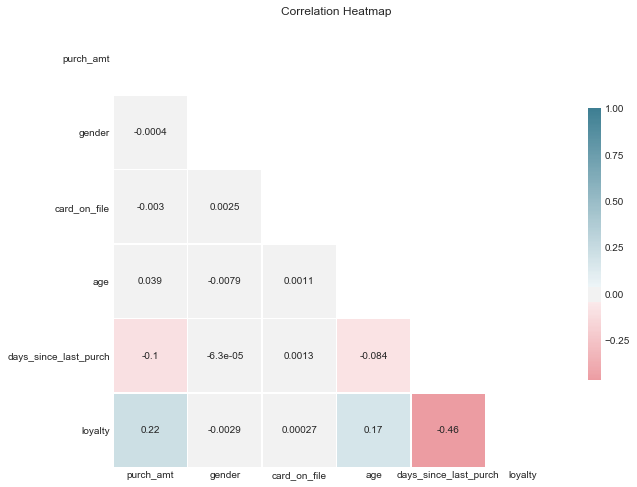

In [13]:
# Create a correlation heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix,
            mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.title('Correlation Heatmap')
plt.show()

### Standardizing data

Some models, such as Logistic Regression and Support Vector Machines perform better when all variables have the same scale.

In [14]:
# Standardize all variables, except the target
std_data = pd.DataFrame(data=preprocessing.scale(cust_data.iloc[:,:-1]),
                        columns=cust_data.columns[:-1])

# add target variable to the data frame
std_data['loyalty'] = cust_data['loyalty']
std_data.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,-1.196185,-0.996684,-1.000115,0.442721,-1.308977,0
1,1.028025,-0.996684,0.999885,-0.437300,0.273046,0
2,-0.170453,1.003327,-1.000115,0.992734,-0.457118,0
3,-0.296839,-0.996684,0.999885,2.202763,0.029658,0
4,-0.006492,-0.996684,0.999885,0.992734,0.455588,0


### Resampling the data set to treat class imbalance
The data set is imbalanced and will need to be resampled: only ~20% of the customers are part of the loyalty program.

In [15]:
# This function splits a data set into train and test samples, and resamples the train samples
def resample(data):
    
    # Shuffle the data set before splitting it to train and test
    shuffled_data = shuffle(data)

    # Set the size of train and test and split the data set
    training_size = int(len(data)*.666) # training data will be 2/3 of all observations
    sample_train = shuffled_data.iloc[:training_size,:]
    x_test = shuffled_data.iloc[training_size:,:-1] # all columns except the target variable
    y_test = shuffled_data.iloc[training_size:,-1] # target variable column

    # Random over sample fraud transactions for training purposes
    ros = RandomOverSampler(ratio='minority')
    x_train_resampled, y_train_resampled = ros.fit_sample(sample_train.iloc[:,:-1], sample_train.iloc[:,-1])

    # Return resampled train values. The test values are returned without resampling
    return x_train_resampled, y_train_resampled, x_test.values, y_test.values

In [16]:
# Split and resample the train data
x_train, y_train, x_test, y_test = resample(std_data)

### Cross-validation function
This custom function cross-validates all models returning confusion matrices, precision, and recall scores.

Sklearn defines the Precision and Recall scores as:

    The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    
    The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [17]:
# Define a function to cross-validate all models
def cv_models(model, folds, x_train, y_train, x_test, y_test):
    
    # Start the timer function to inspect the amount of time necessary to run the method
    start_time = time.time()
    
    # This "if" statement makes models run in the main program to prevent infinite multi-processing loops
    if __name__ == '__main__':
        multiprocessing.set_start_method('forkserver', force=True)

        # Fit the model with the selected parameters
        model.fit(x_train, y_train)

        # Cross-validate the model 
        print('\nCross-Validation:')

        # Split the data set to the number of folds
        step = int(len(y_test)/folds)

        # A "for loop" calls the predict function with a sub-sample 1/5th of the size of the test data set
        start = 0
        recall = []
        precision = []
        for i in range(folds):
            stop = start+step

            # Call the predict function for every sub-sample
            model_predicted = model.predict(x_test[start:stop])

            # Print sample range and confusion matrix 
            print('\nSample range: ', start, 'to', stop)
            print(confusion_matrix(model_predicted, y_test[start:stop]))

            # Calculate and print precision and recall scores for every sub-sample
            rec_score = recall_score(y_test[start:stop], model_predicted)
            recall.append(rec_score)
            print('recall: ', rec_score)
            prec_score = precision_score(y_test[start:stop], model_predicted)
            precision.append(prec_score)
            print('precision: ', prec_score)
            
            start += step

        # Calculate the average precision and recall
        print('\nAverage recall = ', np.mean(recall))
        print('Average precision = ', np.mean(precision))

        # Stop the timer function and inspect the time taken to run the method
        print("\n--- time elapsed %s seconds ---" % (time.time() - start_time))

## Naive Bayes

The Naive Bayes Classifier is a simple and fast model. It applies the Bayes Probability Theorem and assumes that all variables are independent. The fit_prior parameter instructs the algorithm whether to learn class prior probabilities or not. If false, a uniform prior is used.

Since the outcome data is binary, the Bernoulli Naive Bayes classifier is used, with return_prior set to "False".

In [18]:
# Instantiate the model
bnb = BernoulliNB(fit_prior=False)

# Call the cross-validation function
cv_models(bnb, 5, x_train, y_train, x_test, y_test) # 5-fold cross validation


Cross-Validation:

Sample range:  0 to 7582
[[4459  236]
 [1828 1059]]
recall:  0.8177606177606178
precision:  0.36681676480775893

Sample range:  7582 to 15164
[[4515  241]
 [1817 1009]]
recall:  0.8072
precision:  0.3570417551309271

Sample range:  15164 to 22746
[[4477  241]
 [1815 1049]]
recall:  0.8131782945736434
precision:  0.36627094972067037

Sample range:  22746 to 30328
[[4490  255]
 [1795 1042]]
recall:  0.8033924441017734
precision:  0.36728939020091644

Sample range:  30328 to 37910
[[4405  247]
 [1830 1100]]
recall:  0.8166295471417966
precision:  0.37542662116040953

Average recall =  0.8116321807155662
Average precision =  0.36656909620413647

--- time elapsed 0.14833903312683105 seconds ---


## KNN Classifier
The KNN classification model sorts the 'K' number of most similar (or nearest) data points. Similarity is measured according to a proximity metric that can be defined in the model's parameters. The algorithm calculates the probability for each vote value $ \frac{votes_i}{k} $ and the value with highest probability is returned.

In [19]:
# Call the KNN classifier with selected parameters
knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=5, leaf_size=20, weights='distance',
                           metric='euclidean', n_jobs=-1)

# Call the cross-validation function
cv_models(knn, 5, x_train, y_train, x_test, y_test) # 5-fold cross validation


Cross-Validation:

Sample range:  0 to 7582
[[4940  430]
 [1347  865]]
recall:  0.667953667953668
precision:  0.3910488245931284

Sample range:  7582 to 15164
[[4954  434]
 [1378  816]]
recall:  0.6528
precision:  0.37192342752962626

Sample range:  15164 to 22746
[[4993  466]
 [1299  824]]
recall:  0.6387596899224807
precision:  0.3881300047103156

Sample range:  22746 to 30328
[[4951  460]
 [1334  837]]
recall:  0.6453353893600616
precision:  0.3855366190695532

Sample range:  30328 to 37910
[[4931  451]
 [1304  896]]
recall:  0.6651818856718634
precision:  0.4072727272727273

Average recall =  0.6540061265816147
Average precision =  0.3887823206350701

--- time elapsed 1.3572461605072021 seconds ---


## Random Forest Classifier

Random Forest is a 'bagging' ensemble model consisting of multiple decision trees. The trees are generated with randomly selected samples of the data, having with varied depths (meaning the numbers of leaves and branches). Trees get a "vote" on the outcome of each observation. The predictions with most votes are returned.

In [20]:
# Call the model with the selected parameters
rfc = ensemble.RandomForestClassifier(bootstrap=False, min_samples_leaf=5, min_samples_split=2,
                                      n_estimators=100, max_features='sqrt', max_depth=10, n_jobs=-1)

# Call the cross-validation function
cv_models(rfc, 5, x_train, y_train, x_test, y_test) # 5-fold cross validation


Cross-Validation:

Sample range:  0 to 7582
[[4957  271]
 [1330 1024]]
recall:  0.7907335907335907
precision:  0.43500424808836025

Sample range:  7582 to 15164
[[4958  262]
 [1374  988]]
recall:  0.7904
precision:  0.4182895850973751

Sample range:  15164 to 22746
[[5039  286]
 [1253 1004]]
recall:  0.7782945736434108
precision:  0.4448382809038547

Sample range:  22746 to 30328
[[5018  283]
 [1267 1014]]
recall:  0.781804163454125
precision:  0.444541867601929

Sample range:  30328 to 37910
[[4939  258]
 [1296 1089]]
recall:  0.8084632516703786
precision:  0.45660377358490567

Average recall =  0.7899391159003011
Average precision =  0.43985555105528495

--- time elapsed 7.489715099334717 seconds ---


## Logistic Regression

Logistic regression can be used to calculate the probability (obtained as the log odds) of getting y=1 (loyalty program member) rather than y=0 (non-member).

In [21]:
# Declare the model with the selected parameters
logit = LogisticRegression(penalty='l1', solver='saga', C=1, warm_start=False,
                           fit_intercept=True, n_jobs=-1)

# Call the custom cross-validation function
cv_models(logit, 5, x_train, y_train, x_test, y_test) # 5-fold cross validation


Cross-Validation:

Sample range:  0 to 7582
[[4915  258]
 [1372 1037]]
recall:  0.8007722007722008
precision:  0.4304690743046907

Sample range:  7582 to 15164
[[4945  254]
 [1387  996]]
recall:  0.7968
precision:  0.4179605539236257

Sample range:  15164 to 22746
[[5006  264]
 [1286 1026]]
recall:  0.7953488372093023
precision:  0.4437716262975779

Sample range:  22746 to 30328
[[5003  265]
 [1282 1032]]
recall:  0.7956823438704703
precision:  0.445980985306828

Sample range:  30328 to 37910
[[4900  250]
 [1335 1097]]
recall:  0.8144023756495917
precision:  0.4510690789473684

Average recall =  0.8006011515003129
Average precision =  0.43785026375601815

--- time elapsed 0.9986047744750977 seconds ---


### Support Vector Machine Classifier
The Support Vector Machine Classifier (SVC) is an effective machine learning method for high dimensional spaces, including when the number of variables (or dimensions) exceeds the number of samples.

In SVC, the data is plotted as points in an n-dimensional space (with 'n' being the number of variables + the cost function).  The term 'support vectors' refers to the vector coordinates of each data point. SVC finds the ideal boundary that differentiates the points into classes. The boundary consists of a hyperplane with an n-minus-one-dimension, that maximizes the sum of the distances between the boundary and the data points, while minimizing the cumulative distance of points on the wrong side of the margin.

It is a computationally expensive method that is considered highly effective for smaller data sets, but problematic on larger data sets.

In [22]:
# Call the model with selected parameters
svc = svm.SVC(cache_size=1000, C=1, decision_function_shape='ovo', kernel='linear', gamma=1)

# Call the custom cross-validation function
cv_models(svc, 5, x_train, y_train, x_test, y_test) # 5-fold cross validation


Cross-Validation:

Sample range:  0 to 7582
[[4870  250]
 [1417 1045]]
recall:  0.806949806949807
precision:  0.42445166531275386

Sample range:  7582 to 15164
[[4904  246]
 [1428 1004]]
recall:  0.8032
precision:  0.4128289473684211

Sample range:  15164 to 22746
[[4954  253]
 [1338 1037]]
recall:  0.8038759689922481
precision:  0.4366315789473684

Sample range:  22746 to 30328
[[4958  254]
 [1327 1043]]
recall:  0.8041634541249036
precision:  0.440084388185654

Sample range:  30328 to 37910
[[4848  245]
 [1387 1102]]
recall:  0.8181143281365999
precision:  0.44274809160305345

Average recall =  0.8072607116407118
Average precision =  0.43134893428345017

--- time elapsed 394.8685381412506 seconds ---


### Gradient Boosting
The gradient boosting classifier used here is an ensemble of "weak" decision trees that are run in sequence. The residuals of each decision tree is used as the outcome to be predicted by the subsequent tree. The cost function used is the sum of the negative log odds. Predictions are given by adding the values of all decision trees.

In [23]:
# Call the model with selected parameters
gbc = ensemble.GradientBoostingClassifier(max_depth=3, loss='exponential', n_estimators=100,
                                          criterion='friedman_mse')

# Call the custom cross-validation function
cv_models(gbc, 5, x_train, y_train, x_test, y_test) # 5-fold cross validation


Cross-Validation:

Sample range:  0 to 7582
[[4870  253]
 [1417 1042]]
recall:  0.8046332046332046
precision:  0.42374949166327774

Sample range:  7582 to 15164
[[4883  251]
 [1449  999]]
recall:  0.7992
precision:  0.40808823529411764

Sample range:  15164 to 22746
[[4944  253]
 [1348 1037]]
recall:  0.8038759689922481
precision:  0.4348008385744235

Sample range:  22746 to 30328
[[4944  250]
 [1341 1047]]
recall:  0.8072474942174248
precision:  0.43844221105527637

Sample range:  30328 to 37910
[[4837  242]
 [1398 1105]]
recall:  0.8203414996288048
precision:  0.44147023571713945

Average recall =  0.8070596334943365
Average precision =  0.42931020246084695

--- time elapsed 9.979147911071777 seconds ---


## Most indicative loyal customer traits

In addition to predicting customer's propensity to join the loyalty program, we want to identify which traits are most indicative of whether or not an individual will join the program. Scikit-learn's Recursive Feature Elimination is used here to order the most important features (or traits) in the data set.

RFE takes an *estimator* to assign weights to features. Valid estimators are machine learning models that have a **fit** method and return a **coef\_** attribute (such as Logistic Regression) or a **feature\_importances_** attribute (such as Random Forests). We'll run RFE with Random Forest as the estimator.

In [26]:
# Declare the estimator model
model = ensemble.RandomForestClassifier()

# Call the RFE function and number of features to be selected
rfe = RFE(model, 1)

# Fit RFE with scaled data
fit = rfe.fit(std_data.iloc[:,:-1], std_data.iloc[:,-1])

# Inspect the results
print("Feature Ranking:", fit.ranking_)

Feature Ranking: [1 5 4 3 2]


#### Write-up:
I started by assessing the quality of the data and noticed that there were no null (or missing) values. I also checked that all categorical variables had suitable values (e.g., all loyalty values were either "true" or "false"). There were samples with negative "age" and "days since last purchase" values, which were dropped. I considered the negative "purchase values" as reimbursements, and kept those samples.

A correlation analysis using Pearson's Standard Correlation Coefficient (r) indicated that the customers with more recent purchases tend to not be part of the loyalty program (r=-0.46). On the other hand, the members of the loyalty program tend to purchase higher amounts (r=0.22).

I used several supervised machine learning classification methods to model customers' propensity to join the loyalty program. Variables were standardized to have a mean of zero and a standard deviation of one. There were only five variables, and therefore dimension reduction (e.g., PCA) was not necessary. Data was split to training (66%) and testing (33%) subsets. Since only 20% of the customers joined the loyalty program, I over-sampled the training subset to ensure that all models were fit with a 50/50% class balance.

A custom cross-validation function was coded. The function splits the testing subset into five "folds" of equal sizes, returning the precision scores (the model's ability to find all of the negative samples) and recall scores (the ability to find all of the positive samples).
The following models were used (with respective results):

- Bernoulli Naive Bayes: Average recall = 0.820, Average precision = 0.372
- KNN Classifier: Average recall = 0.665, Average precision = 0.397
- Random Forest Classifier: Average recall = 0.800, Average precision = 0.440
- Logistic Regression: Average recall =  0.809, Average precision = 0.442
- Support Vector Machine Classifier: Average recall = 0.815, Average precision = 0.438
- Gradient Boosting: Average recall =  0.818, Average precision = 0.431

To identify which “traits” are most indicative of a customer joining the program, I fit the Random Forest Classifier in combination with Scikit-learn's Recursive Feature Elimination (RFE) to order the most important features in the data set. RFE indicated that a customer’s “purchase amount” is the most indicative of joining the loyalty program, followed by “days since last purchase” - which substantiates the conclusions taken from the correlation analysis.